(dl/04-lm)=
# Language Modeling

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/ok-transformer/blob/master/docs/nb/dl/04-lm.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/ok-transformer?style=social)](https://github.com/particle1331/ok-transformer)

---

**Readings**: {cite}`d2l` https://github.com/karpathy/makemore 

## Introduction

In this notebook, we introduce a **character-level** language model. This model can be used to generate new names using a Markov process after learning from a dataset of names. Our focus will be on introducing the overall framework of language modeling that includes probabilistic modeling and optimization. This notebook draws on relevant parts of [this lecture series](https://www.youtube.com/playlist?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ).

## Names dataset

In [1]:
import math
import torch
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib_inline import backend_inline

DATASET_DIR = Path("./data").absolute()
RANDOM_SEED = 0
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats("svg")

Downloading the dataset:

In [2]:
!wget -O ./data/surnames_freq_ge_100.csv https://raw.githubusercontent.com/jvalhondo/spanish-names-surnames/fdce099ecb22d3b10da76448e1a7787048f12f26/surnames_freq_ge_100.csv
!wget -O ./data/surnames_freq_ge_20_le_99.csv https://raw.githubusercontent.com/jvalhondo/spanish-names-surnames/fdce099ecb22d3b10da76448e1a7787048f12f26/surnames_freq_ge_20_le_99.csv
col = ["surname", "frequency_first", "frequency_second", "frequency_both"]
df1 = pd.read_csv(DATASET_DIR / "surnames_freq_ge_100.csv", names=col, header=0)
df2 = pd.read_csv(DATASET_DIR / "surnames_freq_ge_20_le_99.csv", names=col, header=0)

--2024-03-14 04:13:41--  https://raw.githubusercontent.com/jvalhondo/spanish-names-surnames/fdce099ecb22d3b10da76448e1a7787048f12f26/surnames_freq_ge_100.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 485781 (474K) [text/plain]
Saving to: ‘./data/surnames_freq_ge_100.csv’

./data/surnames_fre 100%[===================>] 474.40K   883KB/s    in 0.5s    

2024-03-14 04:13:42 (883 KB/s) - ‘./data/surnames_freq_ge_100.csv’ saved [485781/485781]

--2024-03-14 04:13:42--  https://raw.githubusercontent.com/jvalhondo/spanish-names-surnames/fdce099ecb22d3b10da76448e1a7787048f12f26/surnames_freq_ge_20_le_99.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 848727 (829K) [text/plain]
Saving to: ‘./data/surnames_freq_ge_20_le_99.csv’

./data/surnames_fre 100%[===================>] 828.83K  4.20MB/s    in 0.2s    

2024-03-14 04:13:43 (4.20 MB/s) - ‘./data/surnames_freq_ge_20_le_99.csv’ saved [848727/848727]



In [3]:
FRAC_LIMIT = 0.30
df = pd.concat([df1, df2], axis=0)[['surname']].sample(frac=FRAC_LIMIT)
df['surname'] = df['surname'].map(lambda s: s.lower())
df['surname'] = df['surname'].map(lambda s: s.replace("de la", "dela"))
df['surname'] = df['surname'].map(lambda s: s.replace(" ", "_"))

names = [n for n in df.surname.tolist() if "'" not in n and 'ç' not in n and len(n) >= 2]
df = df[['surname']].dropna().astype(str)
df = df[df.surname.isin(names)]
df.to_csv(DATASET_DIR / 'spanish_surnames.csv', index=False)
df = pd.read_csv(DATASET_DIR / 'spanish_surnames.csv').dropna()
df.head()

,surname
0,gayola
1,sanchez_pobre
2,cuadal
3,bonifacio
4,quiles


All characters:

In [4]:
s = set(c for n in names for c in n)
chars = "".join(sorted(list(s)))
NUM_CHARS = len(chars)

print(chars)
print(NUM_CHARS)

_abcdefghijklmnopqrstuvwxyzñ
28


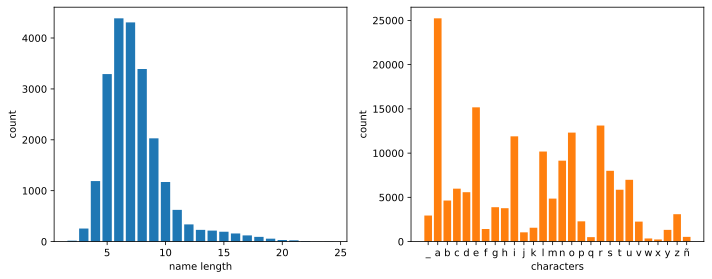

In [5]:
from collections import Counter

length_count = Counter([len(n) for n in names])
char_count = Counter("".join(names))

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].bar(length_count.keys(), length_count.values())
ax[0].set_xlabel("name length", fontsize=10)
ax[0].set_ylabel("count", fontsize=10)

keys = sorted(char_count.keys())
ax[1].set_ylabel("count")
ax[1].set_xlabel("characters")
ax[1].bar(keys, [char_count[k] for k in keys], color="C1")
fig.tight_layout()

Range of name lengths:

In [6]:
print("min:", min(length_count.keys()))
print("max:", max(length_count.keys()))
print("median:", int(np.median(sorted([len(n) for n in names]))))

min: 2
max: 24
median: 7


### Names as sequences

A name is technically a sequence of characters. The primary task of **language modeling** is to assign probabilities to sequences. Recall that we can write a joint distribution as a chain of conditional distributions:

$$
p(\boldsymbol{\mathsf x}_1, \ldots,\boldsymbol{\mathsf x}_n) = p(\boldsymbol{\mathsf x}_1) \prod_{t = 1}^{n-1} p(\boldsymbol{\mathsf x}_{t+1} \mid \boldsymbol{\mathsf x}_{1}, \ldots, \boldsymbol{\mathsf x}_{t}).
$$

In practice, we condition on a **context** consisting of previous characters $(\boldsymbol{\mathsf x}_{t-k+1}, \ldots, \boldsymbol{\mathsf x}_{t})$ of fixed size $k$ to approximate the conditional probability of $\boldsymbol{\mathsf x}_{t+1}.$ 
This is due to architectural constraints in our models. For example, we can create input-output pairs for the name `olivia` with context size 2: 

```
ol -> i
li -> v
iv -> a
``` 

These contexts are called **trigrams**. For context size 1, the pairs are called **bigrams**. In this notebook we will focus on bigrams, i.e. predicting the next character using a single character as context. And maybe look at how results improve by using a larger context.

**Padding.** Because our names are not infinite sequences, we have to model the start and end of names. We do this by introducing special characters for them and incorporating these into the dataset. For example:

```
[o -> l
li -> v
iv -> a
va -> ]
```

This way our models also learn how to start and end names. But observe that it suffices to use a single character `.` to indicate the start and end of a name. Sort of like a record button is pressed twice to record the characters.

```
.. -> o
ol -> i
li -> v
iv -> a
va -> .
```

Note that we use two dots (i.e. equal to the number of context) since we want the model to start from nothing to the first character.

### Dataset class

From the discussion above, we want to sample input-output pairs of each character and its context from names to model the conditional probabilities. This is implemented by the following class which builds all subsequences of characters $(\boldsymbol{\mathsf x}_{t-k+1}, \ldots,\boldsymbol{\mathsf x}_{t})$ of a name as input and the next character $\boldsymbol{\mathsf x}_{t+1}$ as the corresponding target to form our character-level dataset. 

For our purposes, the encoding simply maps characters to integers.

In [7]:
import torch
from torch.utils.data import Dataset

class CharDataset(Dataset):
    def __init__(self, contexts: list[str], targets: list[str], chars: str):
        self.chars = chars
        self.ys = targets
        self.xs = contexts
        self.block_size = len(contexts[0])
        self.itos = {i: c for i, c in enumerate(self.chars)}
        self.stoi = {c: i for i, c in self.itos.items()}

    def get_vocab_size(self):
        return len(self.chars)
    
    def __len__(self):
        return len(self.xs)
    
    def __getitem__(self, idx):
        x = self.encode(self.xs[idx])
        y = torch.tensor(self.stoi[self.ys[idx]]).long()
        return x, y 
        
    def decode(self, x: torch.tensor) -> str:
        return "".join([self.itos[c.item()] for c in x])

    def encode(self, word: str) -> torch.tensor:
        return torch.tensor([self.stoi[c] for c in word]).long()


def build_dataset(names, block_size=3):
    """Build word context -> next char target lists from names."""
    xs = []     # context list
    ys = []     # target list
    for name in names:
        context = ["."] * block_size
        for c in name + ".":
            xs.append(context)
            ys.append(c)
            context = context[1:] + [c]
    
    chars = sorted(list(set("".join(ys))))
    return CharDataset(contexts=xs, targets=ys, chars=chars)

Using this we can create sequence datasets of arbitrary context size.

In [8]:
dataset = build_dataset(names, block_size=3)
xs = []
ys = []
for i in range(7):
    x, y = dataset[i]
    xs.append(x)
    ys.append(y)

pd.DataFrame({'x': [x.tolist() for x in xs], 'y': [y.item() for y in ys], 'x_word': ["".join(dataset.decode(x)) for x in xs], 'y_char': [dataset.itos[c.item()] for c in ys]})

,x,y,x_word,y_char
0,"[0, 0, 0]",8,...,g
1,"[0, 0, 8]",2,..g,a
2,"[0, 8, 2]",26,.ga,y
3,"[8, 2, 26]",16,gay,o
4,"[2, 26, 16]",13,ayo,l
5,"[26, 16, 13]",2,yol,a
6,"[16, 13, 2]",0,ola,.


## Counting *n*-grams

Bigrams can be thought of as input-output pairs with context size 1. An entry `[i, j]` in the array below is the count of bigrams that start with the `i`th character followed by the `j`th character. Recall that we use `.` to signify the start of a name which will be closed by another `.` to signify its end. Iterating over all names to get all existing bigrams:

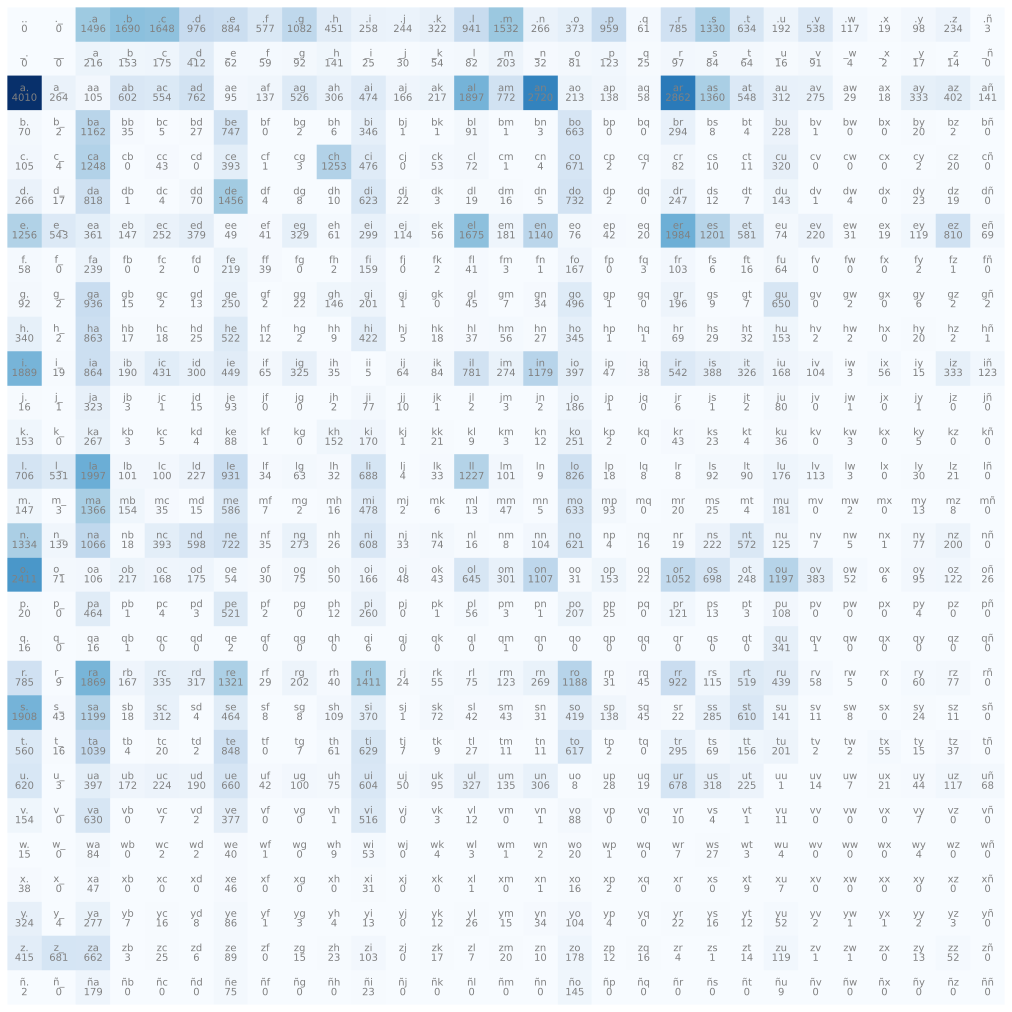

In [9]:
names_train = names[:int(0.80 * len(names))]
names_valid = names[int(0.80 * len(names)):]
bigram_train = build_dataset(names_train, block_size=1)
bigram_valid = build_dataset(names_valid, block_size=1)

# Create count matrix
n = bigram_train.get_vocab_size()
N2 = torch.zeros((n, n), dtype=torch.int32)
for x, y in bigram_train:
    N2[x[0].item(), y.item()] += 1

# Visualize count matrix
plt.figure(figsize=(18, 18))
plt.imshow(N2, cmap='Blues')
for i in range(N2.shape[0]):
    for j in range(N2.shape[1]):
        chstr = bigram_train.itos[i] + bigram_train.itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N2[i, j].item(), ha="center", va="top", color="gray")

plt.axis("off");

In [10]:
print(sum([int(n[0]  == "a") for n in names_train]))
print(sum([int(n[-1] == "a") for n in names_train]))

1496
4010


Note distribution of targets (i.e. characters) are similar in train and validations sets:

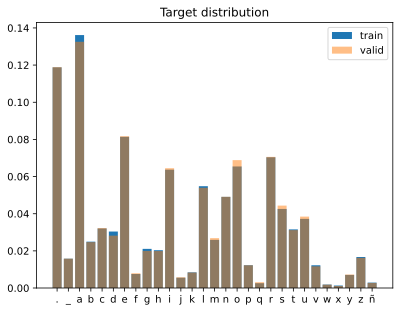

In [11]:
from collections import Counter

train_count = Counter(bigram_train.ys)
valid_count = Counter(bigram_valid.ys)
train_total = sum(train_count.values(), 0.0)
valid_total = sum(valid_count.values(), 0.0)
for k in train_count: train_count[k] /= train_total
for k in valid_count: valid_count[k] /= valid_total

plt.title("Target distribution")
plt.bar(*list(zip(*sorted(train_count.items()))), label="train")
plt.bar(*list(zip(*sorted(valid_count.items()))), alpha=0.5, label="valid")
plt.legend();

### Generating names

Already at this point we can generate names. Recall that we can write joint distributions as a chain of conditional probabilities. But that we condition only on limited context as a form of truncation or approximation. This process can also used as an algorithm to generate names. 

First, a character is sampled given the start context (i.e. `..` for trigrams). The context shifts by appending it with the last sampled character to sample a new one. For example, we adjust the context to `.e` after sampling `e` from `..`. This is repeated until we sample another `.` which indicates the end of a name.

In [12]:
def generate_names(model, dataset, sample_size, seed=2147483647):
    """Generate names from a Markov process with cond proba from model."""

    g = torch.Generator().manual_seed(seed)
    block_size = dataset.block_size
    names = []
    for _ in range(sample_size):
        out = []
        context = "." * block_size
        while True:
            x = torch.tensor(dataset.encode(context))[None, :]
            j = torch.multinomial(model(x)[0], num_samples=1, replacement=True, generator=g).item()
            if j == 0:
                break
            context = context[1:] + dataset.itos[j]
            out.append(dataset.itos[j])
        names.append("".join(out))
    return names

Generating names from conditional distributions estimated by counting bigrams:

In [13]:
P2 = (N2 + 0.01) / (N2 + 0.01).sum(dim=1, keepdim=True)
for name in generate_names(lambda x: P2[tuple(x)], bigram_train, sample_size=12, seed=0):
    print(name)

s
belaririmiñe
s
er
halabarzamigereñeba
doitan_mbamco
peso
cunaifroci
waro
bide
ge
ejasaceceicoo


Trying out trigrams. Note smoothing for zero counts:

In [14]:
trigram_train = build_dataset(names_train, block_size=2)
trigram_valid = build_dataset(names_valid, block_size=2)

# Create count matrix
n = trigram_train.get_vocab_size()
N3 = torch.zeros((n, n, n), dtype=torch.int32)
for x, y in trigram_train:
    N3[x[0].item(), x[1].item(), y.item()] += 1

P3 = (N3 + 0.01) / (N3 + 0.01).sum(dim=-1, keepdim=True)
for name in generate_names(lambda x: P3[tuple(x[0])][None, :], trigram_train, sample_size=12, seed=0):
    print(name)

sa
elarry
more
sala
halabbazamigereñerne
diano_mez_coriescabunaiftoch
waro
bidghippijastenceirookhi
sansiemel_gh
motchailcaurbosahifedar
anat
murragabudigslarmariz


**Remark.** Names generated from bigrams look pretty bad, but still looks better than random. One straightforward way to improve this is to increase context size as we did above. But this solution does not scale to *n*-grams due to [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law) where the next probable *n*-gram has a probability that drops exponentially from the last. Increasing the context size results in a longer tail.

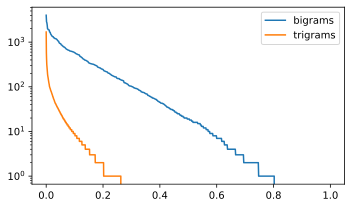

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(np.linspace(0, 1, N2.reshape(-1).shape[0]), sorted(N2.reshape(-1), reverse=True), label="bigrams")
ax.plot(np.linspace(0, 1, N3.reshape(-1).shape[0]), sorted(N3.reshape(-1), reverse=True), label="trigrams", color="C1")
ax.set_yscale("log")
ax.legend()
fig.tight_layout()

### Model quality: NLL

To measure model quality we use [maximum likelihood estimation](https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/maximum-likelihood.html#the-maximum-likelihood-principle) (MLE). That is, we choose model parameters $\boldsymbol{\Theta}$ that maximizes the probability of the dataset. For our character-level language model, our objective will be to maximize the probability assigned by the model to the next character:

$$
\hat p(\boldsymbol{\mathsf{x}}_{t} \mid \boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_{t-1}; \boldsymbol{\Theta}).
$$

From the perspective of optimization, it is better to take the negative logarithm of the probability which is a positive function that increases rapidly as the probability goes to zero, and has a nonzero derivative even as the probability goes to 1. Hence, we take the resulting loss function called the **negative log-likelihood** which is equivalent to next-character MLE, but easier to optimize:

$$
\mathcal{L}(\boldsymbol{\Theta}) = \frac{1}{n} \sum_{\boldsymbol{\mathsf{x}}} \sum_t -\log\, \hat p(\boldsymbol{\mathsf{x}}_{t} \mid \boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_{t-1}; \boldsymbol{\Theta})
$$

where $n$ is the total number of characters to predict. Let us compute the NLL of the bigram model after fitting it on the counts. Note that bigram models assign probability using only the previous character, so that $\,\hat p(\boldsymbol{\mathsf{x}}_{t} \mid \boldsymbol{\mathsf{x}}_1, \ldots, \boldsymbol{\mathsf{x}}_{t-1}; \boldsymbol{\Theta}) = f(\boldsymbol{\mathsf{x}}_{t-1}; \boldsymbol{\Theta}).$ 

### Modeling counts

The following works for *n*-grams for all *n*. It models probabilities based on counts with a smoothing parameter $\alpha$. This is needed in case of zero counts, i.e. when contexts are not encountered in the training dataset, the model opts for a uniform distribution. As $\alpha \to \infty$, the output probabilities become more uniform for any input.

In [16]:
class CountingModel:
    def __init__(self, alpha=0.01):
        """Sequence model that uses observed n-grams to estimate next char proba."""
        self.P = None       # cond. prob
        self.N = None       # counts
        self.alpha = alpha  # smoothing zero counts

    def __call__(self, x: torch.tensor) -> torch.tensor:
        return torch.tensor(self.P[tuple(x)])[None, :]

    def fit(self, dataset: CharDataset):
        n = dataset.get_vocab_size()
        self.N = torch.zeros([n + 1] * (dataset.block_size + 1), dtype=torch.int32)
        for x, y in dataset:
            self.N[tuple(x)][y] += 1

        self.P = (self.N + self.alpha)/ (self.N + self.alpha).sum(dim=-1, keepdim=True)

Training the model on input and target sequences:

In [17]:
# Fitting the bigram model
bigram_model = CountingModel()
bigram_model.fit(bigram_train)

Computing the NLL of the bigram model:

In [18]:
import torch.nn.functional as F

@torch.inference_mode()
def evaluate_model(model, dataset, logits=False):
    # Iterate over dataset one-by-one. Slow for large datasets.
    loss = 0.0
    n = 0
    for x, y in dataset:
        out = model(x)
        p = F.softmax(out, dim=1) if logits else out
        loss += -torch.log(p[0][y])
        n += 1
        if n < 12:
            print(f"p({dataset.itos[y.item()]}|{dataset.decode(x)})={p[0][y]:.4f}    nll={-torch.log(p[0][y]):.4f}")

    print("...")
    print(f"nll = {loss / n:.4f} (overall)")

evaluate_model(bigram_model, bigram_valid)

p(p|.)=0.0541    nll=2.9160
p(o|p)=0.1132    nll=2.1789
p(r|o)=0.1079    nll=2.2268
p(r|r)=0.0879    nll=2.4317
p(e|r)=0.1259    nll=2.0721
p(d|e)=0.0312    nll=3.4658
p(o|d)=0.1615    nll=1.8232
p(n|o)=0.1135    nll=2.1758
p(.|n)=0.1823    nll=1.7019
p(l|.)=0.0531    nll=2.9349
p(l|l)=0.1502    nll=1.8958
...
nll = 2.5097 (overall)


In [19]:
# Fitting the bigram model
trigram_model = CountingModel()
trigram_model.fit(trigram_train)
evaluate_model(trigram_model, trigram_valid)

p(p|..)=0.0541    nll=2.9160
p(o|.p)=0.1188    nll=2.1299
p(r|po)=0.1544    nll=1.8681
p(r|or)=0.1340    nll=2.0099
p(e|rr)=0.2104    nll=1.5590
p(d|re)=0.0583    nll=2.8424
p(o|ed)=0.1951    nll=1.6341
p(n|do)=0.1093    nll=2.2140
p(.|on)=0.3251    nll=1.1235
p(l|..)=0.0531    nll=2.9349
p(l|.l)=0.0892    nll=2.4163
...
nll = 2.3406 (overall)


**Remark.** A model that assigns a probability of `1.0` for each next actual character has a perfect NLL of exactly `0.0`. Here our count models get penalized for *n*-grams which occur rarely on the training dataset. Note that a random prediction is given by:

In [20]:
np.log(NUM_CHARS + 1)   # baseline

3.367295829986474

## Neural bigram model

To model bigrams, we consider a neural network with a single layer with a weight tensor $\boldsymbol{\mathsf W}$ of size `(28, 28)` that corresponds to the count matrix above. The relevant row of weights is picked out by computing $\boldsymbol{\mathsf w}_a = \boldsymbol{\mathsf x}_a \boldsymbol{\mathsf W}$ where $\boldsymbol{\mathsf x}_a$ is the one-hot encoding of the input character $a.$ Then, we apply softmax to $\boldsymbol{\mathsf w}_a$ which is a common technique for converting real-valued vectors to probabilities.

The model essentially is initialized with uniform conditional probabilities. The weights are then fine-tuned using SGD such that the probabilities of observed next characters are maximized (i.e. NLL is minimized). This model internally uses one-hot vectors to represent characters:

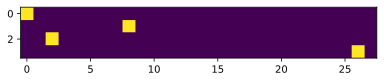

In [21]:
import torch.nn.functional as F
from torch.utils.data import DataLoader

bigram_dl = DataLoader(bigram_train, batch_size=4, shuffle=False)
x, y = next(iter(bigram_dl))
xenc = F.one_hot(x, num_classes=28).float() # convert to float
plt.imshow(xenc.view(4, -1)[:5, :]); # 0, 8, 2, 19

The model is implemented as follows:

In [22]:
class NNBigramModel:
    def __init__(self, alpha=0.01, seed=2147483647):
        self.g = torch.Generator().manual_seed(seed)
        self.W = torch.randn((NUM_CHARS + 1, NUM_CHARS + 1), generator=self.g, requires_grad=True)
        self.alpha = alpha

    def __call__(self, x):
        """Returns p(· | x) over characters."""
        xenc = F.one_hot(x, num_classes=NUM_CHARS + 1).float()
        logits = xenc.view(-1, NUM_CHARS + 1) @ self.W
        counts = logits.exp()
        probs = (counts + self.alpha) / (counts + self.alpha).sum(1, keepdim=True)
        return probs
        
    def zero_grad(self):
        self.W.grad = None

Here weights with values in `(-inf, +inf)` can be interpreted as **log-counts** of bigrams that start on the row index. This is interesting because growth in the negative direction is different from growth in the positive direction. Applying `.exp()` we get units of count with values in `(0, +inf)`. These values are normalized to get an output vector with values in `(0, 1)` which we interpret as a probability distribution. Training the network will make these interpretations valid. 



```{figure} ../../img/bigram-nn.drawio.svg
---
width: 450px
name: bigram-nn.drawio
---

Schematic diagram of the bigram neural net. Computing the probability assigned by the model on `b` given `a` which is represented here as one-hot vector. Note that this is also the backward dependence for a bigram `ab` encountered during training with the NLL loss.
```

**Remark.** This is a pretty weak model (essentially learning a lookup table). A more complex model reflects a different prior regarding the character dependencies. For example, considering long range dependencies such that the generating names have lengths that follow the distribution of names in the dataset. 

### Model training

This should converge to a similar loss value as the bigram counting model (same capacity):

In [23]:
from tqdm.notebook import tqdm

model = NNBigramModel()
bigram_train_loader = DataLoader(bigram_train, batch_size=4096, shuffle=True)
bigram_valid_loader = DataLoader(bigram_valid, batch_size=4096, shuffle=True)

losses = []
num_steps = 500
for k in tqdm(range(num_steps)):
    x, y = next(iter(bigram_train_loader))
    probs = model(x)
    loss = -probs[torch.arange(len(y)), y].log().mean()  # next char nll

    model.zero_grad()
    loss.backward()
    model.W.data -= 10.0 * model.W.grad
    
    # logging
    losses.append(loss.item())
    if k % int(0.10 * num_steps) == 0 or k == num_steps - 1:
        print(f"[{k+1:>03d}/{num_steps}]    loss={loss:.4f}")

  0%|          | 0/500 [00:00<?, ?it/s]

[001/500]    loss=3.8112


[051/500]    loss=2.7564
[101/500]    loss=2.6348
[151/500]    loss=2.6056
[201/500]    loss=2.5463
[251/500]    loss=2.5825
[301/500]    loss=2.5237
[351/500]    loss=2.5068
[401/500]    loss=2.5161
[451/500]    loss=2.5231
[500/500]    loss=2.5276


In [24]:
evaluate_model(model, bigram_valid)

p(p|.)=0.0547    nll=2.9052
p(o|p)=0.1122    nll=2.1874
p(r|o)=0.1054    nll=2.2496
p(r|r)=0.0849    nll=2.4662
p(e|r)=0.1263    nll=2.0690
p(d|e)=0.0296    nll=3.5185
p(o|d)=0.1655    nll=1.7990
p(n|o)=0.1125    nll=2.1847
p(.|n)=0.1774    nll=1.7295
p(l|.)=0.0513    nll=2.9692
p(l|l)=0.1499    nll=1.8978


...
nll = 2.5284 (overall)


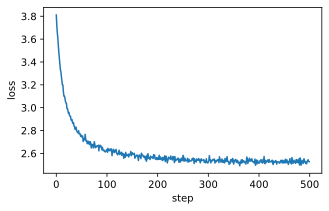

In [25]:
plt.figure(figsize=(5, 3))
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('step');

### Sampling

Generating names and its associated NLL:

In [26]:
def name_loss(name, model, dataset):
    nll = 0.0
    context = "." * dataset.block_size
    for c in name + ".":
        p = model(dataset.encode(context))[0, dataset.stoi[c]]
        nll += -math.log(p)
        context = context[1:] + c
    return nll / (len(name) + 1)


sample = generate_names(model, bigram_train, sample_size=12, seed=0)
name_losses = {n: name_loss(n, model, bigram_train) for n in sample}
for n in sorted(sample, key=lambda n: name_losses[n]):
    print(f"{n:<50} {name_losses[n]:.3f}")

s                                                  1.912
meti                                               2.205
belaririmiña                                       2.232
ge                                                 2.542
sansibanlino                                       2.582
ailchui                                            2.677
wconabide                                          2.707
galabarzamigerepebawaditan_mbamcfeieso             2.816
osahifestr                                         2.848
ejasaceceicoxabi                                   2.948
cunoifroci                                         2.952
_rer                                               3.258


Recall that instead of maximizing names, we are maximizing next character likelihood. Hence, we can get names with low NLL (relative to the random baseline) even if these seem unlikely to occur naturally. Note that this is exactly the strength of generative models. Consequently, it should be rare that a generated name is in the training dataset:

In [27]:
print(r"Generated names found in train dataset:")
sample_size = 1000
print(f"{100 * sum([n in names for n in generate_names(model, bigram_train, sample_size=sample_size)]) / sample_size}% (sample_size={sample_size})")

Generated names found in train dataset:
3.4% (sample_size=1000)


From the conditional distributions, it looks like the neural net recovered the count matrix!

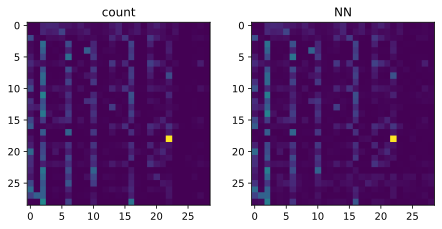

In [28]:
counts = model.W.exp()
P2_nn = (counts / counts.sum(dim=1, keepdim=True)).data

fig, ax = plt.subplots(1, 2)
fig.tight_layout()

ax[0].imshow(P2)
ax[0].set_title("count")
ax[1].imshow(P2_nn)
ax[1].set_title("NN");

**Remark.** That one yellow dot is for "qu". :)

## Character embeddings

In this section, we implement a language model that learns 
**character embeddings**.
Instead of learning a large lookup table for each character sequence, we learn an 
embedding vector for each character which are concatenated to represent a character
sequence. This approach leads to better generalization.

### Network architecture

The architecture {cite}`Bengio2003` is shown in the following figure.

```{figure} ../../img/mlp-char-level.drawio.svg
---
width: 600px
name: mlp-char-level.drawio
---

Schematic diagram of our MLP neural net with embedding and block size of 3. Shown here is the input string `"ner"` passed to the embedding layer. Note that the embeddings are concatenated in the correct order. The resulting concatenation of embeddings are passed to the two-layer MLP with logits.
```

The first component of the network is an embedding matrix, where each row corresponds to an embedding vector. Then, the embedding vectors are concatenated in the correct order and passed to the two-layer MLP. Here the first layer applies tanh nonlinearity, while the second layer simply performs a linear operation to get the logits. 

In [29]:
import torch.nn as nn
from torchinfo import summary

class MLP(nn.Module):
    def __init__(self, 
                 emb_size: int, 
                 width: int, 
                 block_size: int, 
                 vocab_size: int = NUM_CHARS + 1):
        
        super().__init__()
        self.C = nn.Embedding(vocab_size, emb_size)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(block_size * emb_size, width)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(width, vocab_size)

    def forward(self, x):
        x = self.flatten(self.C(x))
        h = self.relu(self.fc1(x))
        z = self.fc2(h)
        return z
    

model = MLP(emb_size=10, width=64, block_size=3)
summary(model, input_data=torch.tensor([[0, 0, 0] for _ in range(32)]))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [32, 29]                  --
├─Embedding: 1-1                         [32, 3, 10]               290
├─Flatten: 1-2                           [32, 30]                  --
├─Linear: 1-3                            [32, 64]                  1,984
├─ReLU: 1-4                              [32, 64]                  --
├─Linear: 1-5                            [32, 29]                  1,885
Total params: 4,159
Trainable params: 4,159
Non-trainable params: 0
Total mult-adds (M): 0.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.02
Estimated Total Size (MB): 0.05

**Remark.** In case we want to regularize the model, weight decay should only be applied to the weights (i.e. not to biases, embeddings, or the like), so that network expressivity is not too strongly limited. See [this post](https://discuss.pytorch.org/t/weight-decay-only-for-weights-of-nn-linear-and-nn-conv/114348) on the PyTorch forums on how to do this.

<br>

**Backpropagation.** Refer to [this section](00-backprop:appendix-backpropagation-equations-for-mlps) for backpropagating across a linear operation. Here we will be mostly interested with backpropagating through the embedding layer. Observe that the gradient of $\bar{\boldsymbol{{\mathsf{x}}}}$ is just the gradient of $\bar{\boldsymbol{{\mathsf{x}}}}_{\text{cat}}$ reshaped. The embedding operation can be written as $\bar{\boldsymbol{{\mathsf{x}}}}_{btj} = \mathsf{C}_{\boldsymbol{\mathsf{x}}_{bt}j}.$ Hence: 

$$
\begin{aligned}
\frac{\partial\mathcal{L}}{\partial\mathsf{C}_{ij}} 
&= \sum_b \sum_t \sum_k \frac{\partial\mathcal{L}}{\partial\bar{\boldsymbol{{\mathsf{x}}}}_{btk}} \frac{\partial\bar{\boldsymbol{{\mathsf{x}}}}_{btk}}{\partial\mathsf{C}_{ij}} \\
&= \sum_b \sum_t \sum_k \frac{\partial\mathcal{L}}{\partial\bar{\boldsymbol{{\mathsf{x}}}}_{btk}} \boldsymbol{\delta}_{\boldsymbol{\mathsf{x}}_{bt}i} \boldsymbol{\delta}_{jk} \\
&= \sum_b \sum_t \boldsymbol{\delta}_{i\boldsymbol{\mathsf{x}}_{bt}}\frac{\partial\mathcal{L}}{\partial\bar{\boldsymbol{{\mathsf{x}}}}_{btj}}.
\end{aligned}
$$

This looks more complicated than it actually is. The last formula is essentially an instruction on where to add the gradients of $\bar{\boldsymbol{{\mathsf{x}}}}$ for entries that are pulled out of $\mathsf{C}.$ However, note that we are summing also over the batch index since these instances **share** the same embedding weights.

In [30]:
x = torch.stack(xs[:4], dim=0)

C = torch.randn(NUM_CHARS + 1, 10, requires_grad=True)
W = torch.randn(30, 4,  requires_grad=True)
b = torch.randn(4,      requires_grad=True)

x̄     = C[x]       
x̄_cat = x̄.view(x̄.shape[0], -1)
y     = x̄_cat @ W + b

for u in [x̄, x̄_cat, y]:
    u.retain_grad()

loss = (y ** 2).sum(dim=1).mean()
loss.backward()

It follows that the gradient of the embedding matrix is:

In [31]:
δ = F.one_hot(x, num_classes=NUM_CHARS + 1).view(-1, NUM_CHARS + 1).float()
dC = δ.T @ x̄.grad.view(-1, 10)

# Checking with autograd
print("maxdiff:", (dC - C.grad).abs().max().item(), "\texact:", torch.all(dC == C.grad).item())

maxdiff: 0.0 	exact: True


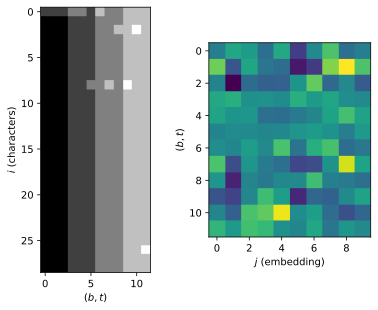

In [32]:
# Three input sequences in a batch (B = 4)
δ = F.one_hot(x, num_classes=NUM_CHARS + 1).view(-1, NUM_CHARS + 1).float().T
δ[:, 3: 6] += 1 # add shade
δ[:, 6: 9] += 2
δ[:, 9:12] += 3

fig, ax = plt.subplots(1, 2)
ax[0].imshow(δ.tolist(), interpolation='nearest', cmap='gray')
ax[0].set_xlabel('$(b, t)$')
ax[0].set_ylabel('$i$ (characters)')

ax[1].imshow(x̄.grad.view(-1, 10), interpolation='nearest')
ax[1].set_ylabel('$(b, t)$')
ax[1].set_xlabel('$j$ (embedding)');

**Figure.** [Kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta) tensor (left) and gradient tensor (right) from the above equation are visualized. The tensor $\boldsymbol{\delta}_{i\boldsymbol{\mathsf{x}}_{bt}}$ indicates all indices $(b, t)$ where the *i*-th character occurs.
All embedding vector gradients $\frac{\partial{\mathcal{L}}}{\partial\bar{\boldsymbol{{\mathsf{x}}}}_{bt:}}$ for the $i$th character are then added over all time steps to get 
$\frac{\partial{\mathcal{L}}}{\partial \mathsf{C}_{i:}}.$ Note that time-dependence can be seen here since the gradients of the embedding for the same character varies over different time steps.

### Model training

We will use our training engine defined on a [previous notebook](03-cnn):

In [33]:
from tqdm.notebook import tqdm
from contextlib import contextmanager
from torch.utils.data import DataLoader

DEVICE = "mps"


@contextmanager
def eval_context(model):
    """Temporarily set to eval mode inside context."""
    state = model.training
    model.eval()
    try:
        yield
    finally:
        model.train(state)


class Trainer:
    def __init__(self,
        model, optim, loss_fn, scheduler=None, callbacks=[],
        device=DEVICE, verbose=True
    ):
        self.model = model
        self.optim = optim
        self.device = device
        self.loss_fn = loss_fn
        self.train_log = {'loss': [], 'loss_avg': []}
        self.valid_log = {'loss': []}
        self.verbose = verbose
        self.scheduler = scheduler
        self.callbacks = callbacks
    
    def __call__(self, x):
        return self.model(x.to(self.device))

    def forward(self, batch):
        x, y = batch
        x = x.to(self.device)
        y = y.to(self.device)
        return self.model(x), y

    def train_step(self, batch):
        preds, y = self.forward(batch)
        loss = self.loss_fn(preds, y)
        loss.backward()
        self.optim.step()
        self.optim.zero_grad()
        return {'loss': loss}

    @torch.inference_mode()
    def valid_step(self, batch):
        preds, y = self.forward(batch)
        loss = self.loss_fn(preds, y, reduction='sum')
        return {'loss': loss}
    
    def run(self, epochs, train_loader, valid_loader, window_size=None):
        for e in tqdm(range(epochs)):
            for i, batch in enumerate(train_loader):
                # optim and lr step
                output = self.train_step(batch)
                if self.scheduler:
                    self.scheduler.step()

                # step callbacks
                for callback in self.callbacks:
                    callback()

                # logs @ train step
                steps_per_epoch = len(train_loader)
                w = int(0.05 * steps_per_epoch) if not window_size else window_size
                self.train_log['loss'].append(output['loss'].item())
                self.train_log['loss_avg'].append(np.mean(self.train_log['loss'][-w:]))

            # logs @ epoch
            output = self.evaluate(valid_loader)
            self.valid_log['loss'].append(output['loss'])
            if self.verbose:
                print(f"[Epoch: {e+1:>0{int(len(str(epochs)))}d}/{epochs}]    loss: {self.train_log['loss_avg'][-1]:.4f}  val_loss: {self.valid_log['loss'][-1]:.4f}")

    def evaluate(self, data_loader):
        with eval_context(self.model):
            valid_loss = 0.0
            for batch in data_loader:
                output = self.valid_step(batch)
                valid_loss += output['loss'].item()

        return {'loss': valid_loss / len(data_loader.dataset)}

    @torch.inference_mode()
    def predict(self, x: torch.Tensor):
        with eval_context(self.model):
            return self(x)

    @torch.inference_mode()
    def batch_predict(self, input_loader: DataLoader):
        with eval_context(self.model):
            preds = [self(x) for x in input_loader]
            preds = torch.cat(preds, dim=0)
        return preds

In [34]:
from torch.optim.lr_scheduler import OneCycleLR

train_dataset = build_dataset(names_train, block_size=3)
valid_dataset = build_dataset(names_valid, block_size=3)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

epochs = 15
model = MLP(emb_size=3, width=64, block_size=3).to(DEVICE)
loss_fn = F.cross_entropy
optim = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = OneCycleLR(optim, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=epochs)
trainer = Trainer(model, optim, loss_fn, scheduler, device=DEVICE)
trainer.run(epochs=epochs, train_loader=train_loader, valid_loader=valid_loader)

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 01/15]    loss: 2.5253  val_loss: 2.5133
[Epoch: 02/15]    loss: 2.4518  val_loss: 2.4501
[Epoch: 03/15]    loss: 2.4124  val_loss: 2.4276
[Epoch: 04/15]    loss: 2.4243  val_loss: 2.4167
[Epoch: 05/15]    loss: 2.4049  val_loss: 2.4059
[Epoch: 06/15]    loss: 2.3899  val_loss: 2.3939
[Epoch: 07/15]    loss: 2.3932  val_loss: 2.3880
[Epoch: 08/15]    loss: 2.3678  val_loss: 2.3897
[Epoch: 09/15]    loss: 2.3942  val_loss: 2.3715
[Epoch: 10/15]    loss: 2.3776  val_loss: 2.3632
[Epoch: 11/15]    loss: 2.3602  val_loss: 2.3536
[Epoch: 12/15]    loss: 2.3399  val_loss: 2.3449
[Epoch: 13/15]    loss: 2.3187  val_loss: 2.3363
[Epoch: 14/15]    loss: 2.3212  val_loss: 2.3318
[Epoch: 15/15]    loss: 2.2897  val_loss: 2.3310


Best performance so far.

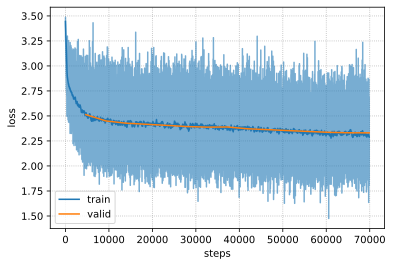

In [35]:
from matplotlib.ticker import StrMethodFormatter

num_epochs = len(trainer.valid_log['loss'])
num_steps_per_epoch = len(trainer.train_log['loss']) // num_epochs

plt.figure(figsize=(6, 4))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter("{x:,.2f}")) # 2 decimal places
plt.plot(np.array(trainer.train_log["loss"]), alpha=0.6, color="C0")
plt.ylabel('loss')
plt.xlabel('steps')
plt.plot(np.array(trainer.train_log["loss_avg"]), color="C0", label="train")
plt.plot(list(range(num_steps_per_epoch, (num_epochs + 1) * num_steps_per_epoch, num_steps_per_epoch)), trainer.valid_log['loss'], label='valid', color="C1")
plt.grid(linestyle="dotted")
plt.legend();

Generated names are looking better:

In [36]:
for n in generate_names(lambda x: F.softmax(model.to("cpu")(x), dim=1), train_dataset, sample_size=12):
    print(n)

bassi
martancia
tarmin
boldia
poles
lana
reuchev
di
mures
magues
paro
ane


Looking at the trained character embeddings:

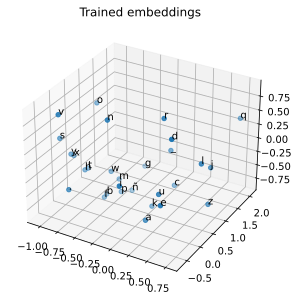

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the embeddings; annotate
embeddings = model.C.weight.data.detach().cpu().numpy()
ax.scatter(embeddings[:,0], embeddings[:,1], embeddings[:,2])
for i, char in enumerate(train_dataset.chars):
    ax.text(embeddings[i,0], embeddings[i, 1], embeddings[i, 2], char)

ax.set_title('Trained embeddings')
plt.show()

**Figure.** Observe that there are vectors that are isolated from other vectors. On the other hand, characters being tightly clustered indicates that the network is not able to understand the subtle differences between them. 

This indicates that embedding dimension may be a bottleneck and therefore can be increased to improve performance. Indeed, performance improved after increasing embedding dimension from 2 to 3 with other variables fixed.

## Appendix: WaveNet

One problem with our previous network is that sequential information from the inputs are mixed or squashed too fast (i.e. in one layer). We can make this network deeper by adding dense layers, but it still does not solve this problem. In this section, we implement a convolutional neural network architecture similar to {cite}`wavenet`. This allows the character embeddings to be fused slowly.

```{figure} ../../img/nn/04-wavenet.png
---
width: 700px
name: wavenet
---
Tree-like structure formed by a stack of dilated convolutional layers. {cite}`wavenet`
```

The structure of the network allows us to use a larger block size. 
Previously, increasing block size by 1 means that the network 
width increases 
equal to the embedding dimension.
For this network, the width is fixed but we have to increase depth.

In [38]:
train_dataset = build_dataset(names_train, block_size=8)
valid_dataset = build_dataset(names_valid, block_size=8)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# visualizing the input-output pairs
for x, y in zip(train_dataset.xs, train_dataset.ys):
    print("".join(x), "-->", y)
    if y == ".": 
        break

........ --> g
.......g --> a
......ga --> y
.....gay --> o
....gayo --> l
...gayol --> a
..gayola --> .


To implement this without using dilated convolutions, we define the following class 
so that only two characters are combined at each step. The linear layer is applied to 
the last dimension which the following layer expands. Here `n` corresponds to the number 
of characters that are combined at each step.

In [39]:
class FlattenConsecutive(nn.Module):
    def __init__(self, n: int):
        super().__init__()
        self.n = n
    
    def forward(self, x):
        B, T, C = x.shape   # (batch, char, emb)
        x = x.view(B, T // self.n, C * self.n)
        return x

Observe that we increase embedding size and width. Moreover, the network is deeper. Information from characters can flow better through the network due to its heirarchical nature. Note that we need three layers to combine all characters: 2 x 2 x 2 = 8 (block size). This looks like our previous network. Stride happens in how character blocks are fed through the network, so convolutions are not explicitly used.

In [40]:
emb_size = 24
width = 128
VOCAB_SIZE = NUM_CHARS + 1

wavenet = nn.Sequential(
    nn.Embedding(VOCAB_SIZE, emb_size),
    FlattenConsecutive(2), nn.Linear(emb_size * 2, width), nn.ReLU(),
    FlattenConsecutive(2), nn.Linear(   width * 2, width), nn.ReLU(),
    FlattenConsecutive(2), nn.Linear(   width * 2, width), nn.ReLU(),
    nn.Linear(width, VOCAB_SIZE), nn.Flatten()
)


epochs = 5
wavenet = wavenet.to(DEVICE)
loss_fn = F.cross_entropy
optim = torch.optim.AdamW(wavenet.parameters(), lr=0.001)
scheduler = OneCycleLR(optim, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=epochs)
trainer = Trainer(wavenet, optim, loss_fn, scheduler, device=DEVICE)
trainer.run(epochs=epochs, train_loader=train_loader, valid_loader=valid_loader)

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 1/5]    loss: 2.4032  val_loss: 2.3935
[Epoch: 2/5]    loss: 2.3724  val_loss: 2.4013
[Epoch: 3/5]    loss: 2.2984  val_loss: 2.2992
[Epoch: 4/5]    loss: 2.2307  val_loss: 2.2250
[Epoch: 5/5]    loss: 2.1816  val_loss: 2.2028


**Remark.** Finally broke through 2.3 loss!

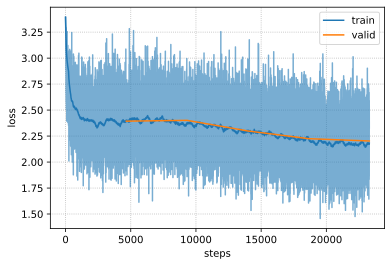

In [41]:
from matplotlib.ticker import StrMethodFormatter

num_epochs = len(trainer.valid_log['loss'])
num_steps_per_epoch = len(trainer.train_log['loss']) // num_epochs

plt.figure(figsize=(6, 4))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter("{x:,.2f}")) # 2 decimal places
plt.plot(np.array(trainer.train_log["loss"]), alpha=0.6, color="C0")
plt.ylabel('loss')
plt.xlabel('steps')
plt.plot(np.array(trainer.train_log["loss_avg"]), color="C0", label="train")
plt.plot(list(range(num_steps_per_epoch, (num_epochs + 1) * num_steps_per_epoch, num_steps_per_epoch)), trainer.valid_log['loss'], label='valid', color="C1")
plt.grid(linestyle="dotted")
plt.legend();

---

■